In [ ]:
# !pip install torchmetrics
# # +++++++++++++++++++++++++++++++++++++++++++
# !pip install roboflow
# # # +++++++++++++++++++++++++++++++++++++++++++
# from roboflow import Roboflow
# rf = Roboflow(api_key="gVyojXfchvmrYzgPJdAS")
# project = rf.workspace("lounisamr").project("ocr-dz")
# dataset = project.version(2).download("yolov8")
# !mv ocr-dz-2 data
# # +++++++++++++++++++++++++++++++++++++++++++
# from roboflow import Roboflow
# rf = Roboflow(api_key="gVyojXfchvmrYzgPJdAS")
# project = rf.workspace("lounisamr").project("car-plate-dzex")
# dataset = project.version(2).download("yolov8")
# !mv car-plate-dzex data

In [103]:
import glob
import os
import math
import sys
import functools
import time
import random
import time
import datetime

import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar
import cv2
import pandas as pd
import numpy as np
import torch
import torchvision
from torchmetrics.detection import MeanAveragePrecision
from torch.utils.data import DataLoader,Dataset,random_split
#
import warnings
warnings.filterwarnings("ignore")
#
from google.colab.patches import cv2_imshow
# def cv2_imshow(img:np.ndarray):
#     cv2.imshow("img",img)
#     cv2.waitKey()



#CONFIG

In [104]:
dataset_path = "data"
model_saved ="model.pth"
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print("device:",device)
# classes_names = ["background","0","1","2","3","4","5","6","7","8","9"]
classes_names = ["background","car","plate"]
num_classes = len(classes_names)
batch_size = 16
num_epochs = 10
imgsz = 320

model_index = 0 # 0 frcmm 1 ssd

device: cuda:0


#DATASET CLASS





In [105]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def get_all_files(directory_path:str,extension:str):
    if os.path.isdir(directory_path):
        _files = []
        for root, dirs, files in os.walk(directory_path):
            _files.extend(glob.glob(os.path.join(root, f"*.{extension}")))
        return _files
    else:
        return []

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def find_pair_files(directory_path:str,extension1:str,extension2:str):
    files1 = get_all_files(directory_path,extension1)
    files2 = get_all_files(directory_path,extension2)

    list_pair1 = []
    list_pair2 = []

    for f1 in files1:
        for f2 in files2:
            basename_f1 = os.path.splitext(os.path.basename(f1))[0]
            basename_f2 = os.path.splitext(os.path.basename(f2))[0]
            if basename_f1 == basename_f2:
                list_pair1.append(f1)
                list_pair2.append(f2)
                break
    print(f"number files pair in folder --: {directory_path} : --is-- :{len(list_pair1)} ")
    return list_pair1,list_pair2

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def read_annotation_yolov8_idxyxy(annotation_path:str,image_width:int, image_height:int):
    with open(annotation_path, 'r') as label_file:
        label_data = label_file.readlines()
    _boxes = []
    _class_ids = []
    for line in label_data:
        r= line.split(" ")

        # One number is added for the background category
        id_class = int(r[0])+1
        xc = float(r[1]) * image_width
        yc = float(r[2]) * image_height
        w =  float(r[3]) * image_width
        h =  float(r[4]) * image_height

        x0 = int( xc - (w/2) )
        y0 = int( yc - (h/2) )
        x1 = int( xc + (w/2) )
        y1 = int( yc + (h/2) )

        _class_ids.append( id_class)
        _boxes.append( [x0,y0,x1,y1])

    return _class_ids , _boxes

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def read_image(path_image:str):
    image = cv2.imread(path_image)
    if image is None or image.size == 0:
        raise IOError('failed to load ' + str(path_image))

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def image_process(image_in,imgsz):
    [height, width, _] = image_in.shape
    if height > width:
        image_rect = np.zeros((height, height, 3), np.uint8)
        image_rect[0:height, 0:width] = image_in
        scale = height / imgsz
    else:
        image_rect = np.zeros((width, width, 3), np.uint8)
        image_rect[0:height, 0:width] = image_in
        scale = width / imgsz

    width_new  = int(width / scale)
    height_new = int(height / scale)

    image_rect = cv2.resize(image_rect, (imgsz,imgsz))
    image_normalize = image_rect / 255.0
    image_3nn = image_normalize.transpose((2, 0, 1))

    image_3nn = image_3nn.astype(np.float32)
    image_3nn = torch.FloatTensor(image_3nn)
    return image_3nn , width_new , height_new

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def imageTensor2imageRGB(images):
    img_int = torch.tensor(images * 255, dtype=torch.uint8).numpy()
    img_int = img_int.transpose((1, 2, 0))
    img_int = cv2.cvtColor(img_int, cv2.COLOR_BGR2RGB)
    return img_int

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def test_tensor(images, targets):
    img_int = imageTensor2imageRGB(images)
    boxes = torch.tensor(targets["boxes"], dtype=torch.float32).numpy().tolist()
    labels = torch.tensor(targets["labels"], dtype=torch.int64).numpy().tolist()
    for box in boxes:
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[2])
        y1 = int(box[3])

        cv2.rectangle(img_int, (x0, y0), (x1, y1), (0, 255, 0), 2)
    cv2_imshow(img_int)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir,transform=None,target_transform =None):
        self.transform = transform

        self.transform = transform
        self.target_transform = target_transform

        self.image_files = []
        self.annotation_files = []
        self.image_files , self.annotation_files = find_pair_files(root_dir,"jpg","txt")

    def __getitem__(self, index):
        image_file = self.image_files[index]
        image_in = read_image(image_file)
        image_tensor , width_new , height_new = image_process(image_in,imgsz)
        class_ids , boxes = read_annotation_yolov8_idxyxy(self.annotation_files[index],width_new,height_new)

        boxes = torch.tensor(np.array(boxes, dtype=np.float32), dtype=torch.float32)
        labels = torch.tensor(np.array(class_ids, dtype=np.int64), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        return image_tensor, target

    def __len__(self):
        return len(self.image_files)


#Read Data

number files pair in folder --: data/train : --is-- :5001 
number files pair in folder --: data/test : --is-- :238 
number files pair in folder --: data/valid : --is-- :475 
5001  --:--  238  --:--  475


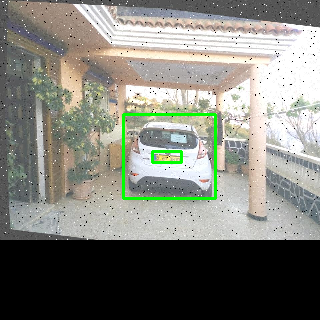

In [ ]:
dataset_train = CustomDataset(os.path.join(dataset_path,"train"))
dataset_test = CustomDataset(os.path.join(dataset_path,"test"))
dataset_validate = CustomDataset(os.path.join(dataset_path,"valid"))

print( len(dataset_train) ," --:-- ", len(dataset_test) ," --:-- ", len(dataset_validate) )
image,target = dataset_train[0]
test_tensor(image,target)

#create loader

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn)

loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False,  collate_fn=collate_fn)

loader_valid = DataLoader(dataset_validate, batch_size=batch_size, shuffle=False,  collate_fn=collate_fn)

#functions

In [106]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
class TimeExe:
  def __init__(self,TAG):
    self.TAG = TAG
    pass
  def begin(self):
    self.start_time = time.time()

  def end(self):
    end_time = time.time()
    elapsed_time = end_time - self.start_time
    print(self.TAG," : Elapsed time : ",elapsed_time,"seconds")
    return elapsed_time

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
COLORS = np.random.uniform(0, 255, size=(len(classes_names), 3))

def predict(image, model, device, detection_threshold):
    image_tensor , width_new , height_new = image_process(image,imgsz)
    image_tensor = [image_tensor.to(device)]
    scale = image.shape[0]/height_new

    outputs = model(image_tensor)
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    boxes_in = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    boxes_out = []
    for box in boxes_in:
            x1 = round(box[0] * scale)
            y1 = round(box[1] * scale)
            x2 = round(box[2] * scale)
            y2 = round(box[3] * scale)
            boxes_out.append([int(x1),int(y1),int(x2),int(y2)])

    labels = outputs[0]['labels'][:len(boxes_out)]
    return boxes_out , labels

def draw_boxes(boxes , labels, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def plot_cost(_costs , key):
    title = f"Epoch vs {key}"
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(np.arange(len(_costs)), _costs, 'r')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(key)
    ax.set_title(title)
    # plt.show()
    plt.savefig(title)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def validate_model(model,loader,device):
  model.to(device)
  model.eval()
  # #https://torchmetrics.readthedocs.io/en/stable/detection/mean_average_precision.html
  metric = MeanAveragePrecision(iou_type="bbox")
  with torch.no_grad():
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        preds = model(images)

        metric.update(preds, targets)
  # from pprint import pprint
  map_result = metric.compute()
  keys = map_result.keys()
  dict_matric = {}
  for key in keys:
    dict_matric[key] = map_result[key].numpy()
  # fig_, ax_  = metric.plot()

  return dict_matric
  # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#trainer

In [107]:
import torch.distributed as dist

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return get_world_size()

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.to(device)
    model.train()

    _lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        _lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    all_losses = []
    all_losses_dict = []
    print(f" \n -------------------- epoch {epoch}")
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if _lr_scheduler is not None:
              _lr_scheduler.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)
    dict_r = all_losses_dict.mean(axis=0).to_dict()
    dict_r["lr"] = optimizer.param_groups[0]["lr"]
    return dict_r

In [108]:
if model_index == 0:
  print("F-RCNN")
  if not os.path.exists(model_saved):
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    print("created new model")
  else:
    model = torch.load(model_saved)
    print(f"load model :{model_saved}")

elif model_index == 1:
  print("SSD")
  if not os.path.exists(model_saved):
    model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)
    in_channels = torchvision.models.detection._utils.retrieve_out_channels(model.backbone, (imgsz, imgsz))
    num_anchors = model.anchor_generator.num_anchors_per_location()
    norm_layer = functools.partial(torch.nn.BatchNorm2d, eps=0.001, momentum=0.03)

    model.head.classification_head = torchvision.models.detection.ssdlite.SSDLiteClassificationHead(in_channels, num_anchors, num_classes, norm_layer)
    print("created new model")
  else:
    model = torch.load(model_saved)
    print(f"load model :{model_saved}")

F-RCNN
created new model


#train

In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.05, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
t_all = TimeExe("t_all")
t_all.begin()

losses_dict_all = []
map_dict_all = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    losses_dict_this = train_one_epoch(model, optimizer, loader_train, device, epoch, print_freq=1)
    print(losses_dict_this)
    losses_dict_all.append(losses_dict_this)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    print("---------- validate ")
    dict_valid = validate_model(model, loader_test, device=device)
    print(dict_valid)
    map_dict_all.append(dict_valid)

    t_all.end()

t_all.end()

 
 -------------------- epoch 0


100%|██████████| 313/313 [01:36<00:00,  3.23it/s]


{'bbox_regression': 0.319724016201001, 'classification': 1.8092989171274936, 'lr': 0.04999999999999991}
---------- validate 


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


{'map': array(0.50058156, dtype=float32), 'map_50': array(0.90587837, dtype=float32), 'map_75': array(0.51430464, dtype=float32), 'map_small': array(0.22495143, dtype=float32), 'map_medium': array(0.19556059, dtype=float32), 'map_large': array(0.6961786, dtype=float32), 'mar_1': array(0.5582616, dtype=float32), 'mar_10': array(0.5891159, dtype=float32), 'mar_100': array(0.59750175, dtype=float32), 'mar_small': array(0.35877192, dtype=float32), 'mar_medium': array(0.39233872, dtype=float32), 'mar_large': array(0.7487395, dtype=float32), 'map_per_class': array(-1., dtype=float32), 'mar_100_per_class': array(-1., dtype=float32), 'classes': array([1, 2], dtype=int32)}
t_all  : Elapsed time :  104.54558205604553 seconds
 
 -------------------- epoch 1


100%|██████████| 313/313 [01:36<00:00,  3.24it/s]


{'bbox_regression': 0.2490951891143482, 'classification': 1.0697596038873203, 'lr': 0.04999999999999991}
---------- validate 


100%|██████████| 15/15 [00:04<00:00,  3.07it/s]


{'map': array(0.58711374, dtype=float32), 'map_50': array(0.9635513, dtype=float32), 'map_75': array(0.5984915, dtype=float32), 'map_small': array(0.32139075, dtype=float32), 'map_medium': array(0.25692785, dtype=float32), 'map_large': array(0.7619433, dtype=float32), 'mar_1': array(0.633006, dtype=float32), 'mar_10': array(0.64538693, dtype=float32), 'mar_100': array(0.6489583, dtype=float32), 'mar_small': array(0.39210525, dtype=float32), 'mar_medium': array(0.44959676, dtype=float32), 'mar_large': array(0.80210084, dtype=float32), 'map_per_class': array(-1., dtype=float32), 'mar_100_per_class': array(-1., dtype=float32), 'classes': array([1, 2], dtype=int32)}
t_all  : Elapsed time :  209.86451029777527 seconds
 
 -------------------- epoch 2


100%|██████████| 313/313 [01:37<00:00,  3.21it/s]


{'bbox_regression': 0.18128522195088598, 'classification': 0.891662506249766, 'lr': 0.04999999999999991}
---------- validate 


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


{'map': array(0.6098568, dtype=float32), 'map_50': array(0.95428956, dtype=float32), 'map_75': array(0.58834296, dtype=float32), 'map_small': array(0.3624242, dtype=float32), 'map_medium': array(0.22788286, dtype=float32), 'map_large': array(0.8207578, dtype=float32), 'mar_1': array(0.6632458, dtype=float32), 'mar_10': array(0.6827731, dtype=float32), 'mar_100': array(0.6859156, dtype=float32), 'mar_small': array(0.45964912, dtype=float32), 'mar_medium': array(0.4125, dtype=float32), 'mar_large': array(0.85714287, dtype=float32), 'map_per_class': array(-1., dtype=float32), 'mar_100_per_class': array(-1., dtype=float32), 'classes': array([1, 2], dtype=int32)}
t_all  : Elapsed time :  314.1907308101654 seconds
 
 -------------------- epoch 3


100%|██████████| 313/313 [01:35<00:00,  3.28it/s]


{'bbox_regression': 0.10702698955092187, 'classification': 0.658625816003964, 'lr': 0.004999999999999991}
---------- validate 


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


{'map': array(0.7684578, dtype=float32), 'map_50': array(0.9895465, dtype=float32), 'map_75': array(0.87224156, dtype=float32), 'map_small': array(0.5658652, dtype=float32), 'map_medium': array(0.3583429, dtype=float32), 'map_large': array(0.9032381, dtype=float32), 'mar_1': array(0.81186277, dtype=float32), 'mar_10': array(0.81647235, dtype=float32), 'mar_100': array(0.8173057, dtype=float32), 'mar_small': array(0.6377193, dtype=float32), 'mar_medium': array(0.65685487, dtype=float32), 'mar_large': array(0.9344538, dtype=float32), 'map_per_class': array(-1., dtype=float32), 'mar_100_per_class': array(-1., dtype=float32), 'classes': array([1, 2], dtype=int32)}
t_all  : Elapsed time :  417.0339286327362 seconds
 
 -------------------- epoch 4


100%|██████████| 313/313 [01:37<00:00,  3.22it/s]


{'bbox_regression': 0.0873112109855722, 'classification': 0.5821779257954119, 'lr': 0.004999999999999991}
---------- validate 


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


{'map': array(0.77139693, dtype=float32), 'map_50': array(0.98886836, dtype=float32), 'map_75': array(0.8753048, dtype=float32), 'map_small': array(0.5735751, dtype=float32), 'map_medium': array(0.35658914, dtype=float32), 'map_large': array(0.9072691, dtype=float32), 'mar_1': array(0.81584734, dtype=float32), 'mar_10': array(0.8192017, dtype=float32), 'mar_100': array(0.8204552, dtype=float32), 'mar_small': array(0.6403509, dtype=float32), 'mar_medium': array(0.5862903, dtype=float32), 'mar_large': array(0.93613446, dtype=float32), 'map_per_class': array(-1., dtype=float32), 'mar_100_per_class': array(-1., dtype=float32), 'classes': array([1, 2], dtype=int32)}
t_all  : Elapsed time :  521.4681231975555 seconds
 
 -------------------- epoch 5


100%|██████████| 313/313 [01:35<00:00,  3.28it/s]


{'bbox_regression': 0.07926025823615611, 'classification': 0.5390652852317396, 'lr': 0.004999999999999991}
---------- validate 


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


{'map': array(0.76520026, dtype=float32), 'map_50': array(0.9877826, dtype=float32), 'map_75': array(0.867567, dtype=float32), 'map_small': array(0.557732, dtype=float32), 'map_medium': array(0.3543597, dtype=float32), 'map_large': array(0.8986388, dtype=float32), 'mar_1': array(0.80997896, dtype=float32), 'mar_10': array(0.815014, dtype=float32), 'mar_100': array(0.81626576, dtype=float32), 'mar_small': array(0.64824563, dtype=float32), 'mar_medium': array(0.6024194, dtype=float32), 'mar_large': array(0.9327731, dtype=float32), 'map_per_class': array(-1., dtype=float32), 'mar_100_per_class': array(-1., dtype=float32), 'classes': array([1, 2], dtype=int32)}
t_all  : Elapsed time :  624.76087474823 seconds
 
 -------------------- epoch 6


100%|██████████| 313/313 [01:37<00:00,  3.21it/s]


{'bbox_regression': 0.07222379585757804, 'classification': 0.49775229484890215, 'lr': 0.0004999999999999991}
---------- validate 


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


{'map': array(0.78070605, dtype=float32), 'map_50': array(0.9881906, dtype=float32), 'map_75': array(0.89838487, dtype=float32), 'map_small': array(0.59325534, dtype=float32), 'map_medium': array(0.365844, dtype=float32), 'map_large': array(0.9049087, dtype=float32), 'mar_1': array(0.82382876, dtype=float32), 'mar_10': array(0.82802343, dtype=float32), 'mar_100': array(0.82969713, dtype=float32), 'mar_small': array(0.6675439, dtype=float32), 'mar_medium': array(0.591129, dtype=float32), 'mar_large': array(0.9365546, dtype=float32), 'map_per_class': array(-1., dtype=float32), 'mar_100_per_class': array(-1., dtype=float32), 'classes': array([1, 2], dtype=int32)}
t_all  : Elapsed time :  729.9644491672516 seconds
 
 -------------------- epoch 7


100%|██████████| 313/313 [01:36<00:00,  3.24it/s]


{'bbox_regression': 0.07175089389133377, 'classification': 0.491440830805812, 'lr': 0.0004999999999999991}
---------- validate 


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


{'map': array(0.78062296, dtype=float32), 'map_50': array(0.9881257, dtype=float32), 'map_75': array(0.9075031, dtype=float32), 'map_small': array(0.59878653, dtype=float32), 'map_medium': array(0.36225504, dtype=float32), 'map_large': array(0.9050647, dtype=float32), 'mar_1': array(0.82319677, dtype=float32), 'mar_10': array(0.82739145, dtype=float32), 'mar_100': array(0.82906514, dtype=float32), 'mar_small': array(0.67192984, dtype=float32), 'mar_medium': array(0.5875, dtype=float32), 'mar_large': array(0.93697476, dtype=float32), 'map_per_class': array(-1., dtype=float32), 'mar_100_per_class': array(-1., dtype=float32), 'classes': array([1, 2], dtype=int32)}
t_all  : Elapsed time :  835.4434804916382 seconds
 
 -------------------- epoch 8


100%|██████████| 313/313 [01:36<00:00,  3.23it/s]


{'bbox_regression': 0.07105437782816232, 'classification': 0.4890663219145693, 'lr': 0.0004999999999999991}
---------- validate 


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


{'map': array(0.77979714, dtype=float32), 'map_50': array(0.9880736, dtype=float32), 'map_75': array(0.8976429, dtype=float32), 'map_small': array(0.58614284, dtype=float32), 'map_medium': array(0.36545828, dtype=float32), 'map_large': array(0.90734416, dtype=float32), 'mar_1': array(0.82151437, dtype=float32), 'mar_10': array(0.82549894, dtype=float32), 'mar_100': array(0.82717264, dtype=float32), 'mar_small': array(0.654386, dtype=float32), 'mar_medium': array(0.59153223, dtype=float32), 'mar_large': array(0.937395, dtype=float32), 'map_per_class': array(-1., dtype=float32), 'mar_100_per_class': array(-1., dtype=float32), 'classes': array([1, 2], dtype=int32)}
t_all  : Elapsed time :  941.5044963359833 seconds
 
 -------------------- epoch 9


100%|██████████| 313/313 [01:34<00:00,  3.30it/s]


{'bbox_regression': 0.07048680752325363, 'classification': 0.4831484539059404, 'lr': 4.9999999999999914e-05}
---------- validate 


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


{'map': array(0.7811511, dtype=float32), 'map_50': array(0.9880122, dtype=float32), 'map_75': array(0.9020126, dtype=float32), 'map_small': array(0.5973444, dtype=float32), 'map_medium': array(0.36421904, dtype=float32), 'map_large': array(0.9068612, dtype=float32), 'mar_1': array(0.823827, dtype=float32), 'mar_10': array(0.8282318, dtype=float32), 'mar_100': array(0.82990545, dtype=float32), 'mar_small': array(0.67105263, dtype=float32), 'mar_medium': array(0.5895161, dtype=float32), 'mar_large': array(0.93697476, dtype=float32), 'map_per_class': array(-1., dtype=float32), 'mar_100_per_class': array(-1., dtype=float32), 'classes': array([1, 2], dtype=int32)}
t_all  : Elapsed time :  1045.6344666481018 seconds
t_all  : Elapsed time :  1045.6356818675995 seconds


1045.6356818675995

In [ ]:
def save_list_dict(_data,_path):
  timestr = time.strftime("%Y%m%d-%H%M%S")
  random_str = str(random.randint(0, 999999999)).zfill(10)
  _path_gen = f"{_path}_{timestr}_{random_str}.csv"
  print("save :",_path_gen)
  losses_dict_all = pd.DataFrame(_data)
  losses_dict_all.to_csv(_path_gen,index=False)

save_list_dict(losses_dict_all,"loss")
print(losses_dict_all)

save_list_dict(map_dict_all,"map")
print(map_dict_all)

save : loss_20230830-114257_0197222641.csv
[{'bbox_regression': 0.319724016201001, 'classification': 1.8092989171274936, 'lr': 0.04999999999999991}, {'bbox_regression': 0.2490951891143482, 'classification': 1.0697596038873203, 'lr': 0.04999999999999991}, {'bbox_regression': 0.18128522195088598, 'classification': 0.891662506249766, 'lr': 0.04999999999999991}, {'bbox_regression': 0.10702698955092187, 'classification': 0.658625816003964, 'lr': 0.004999999999999991}, {'bbox_regression': 0.0873112109855722, 'classification': 0.5821779257954119, 'lr': 0.004999999999999991}, {'bbox_regression': 0.07926025823615611, 'classification': 0.5390652852317396, 'lr': 0.004999999999999991}, {'bbox_regression': 0.07222379585757804, 'classification': 0.49775229484890215, 'lr': 0.0004999999999999991}, {'bbox_regression': 0.07175089389133377, 'classification': 0.491440830805812, 'lr': 0.0004999999999999991}, {'bbox_regression': 0.07105437782816232, 'classification': 0.4890663219145693, 'lr': 0.000499999999

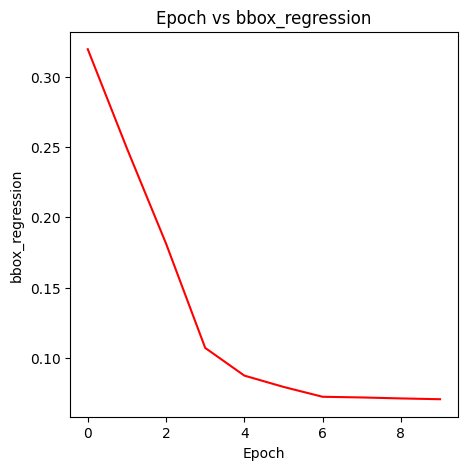

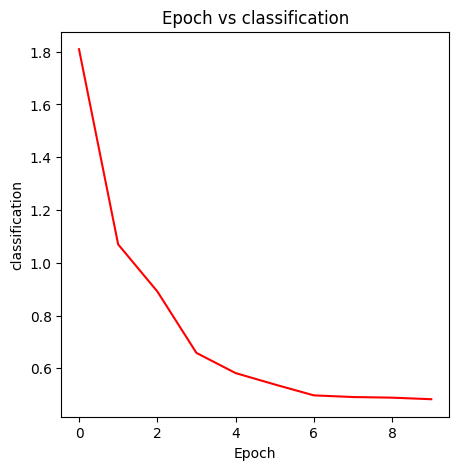

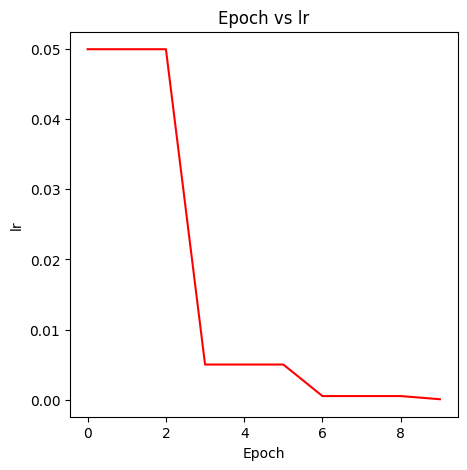

In [ ]:
df_losses = pd.DataFrame(losses_dict_all)
keys = df_losses.keys()
for key in keys:
  plot_cost(df_losses[key],key)

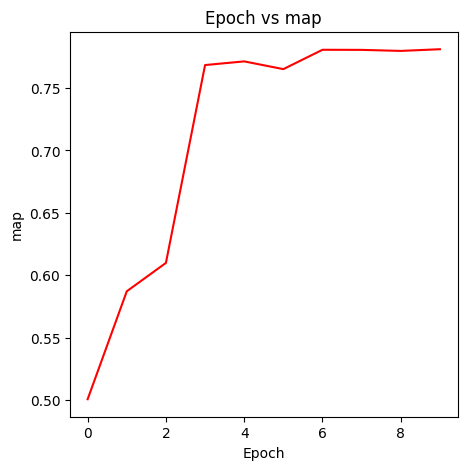

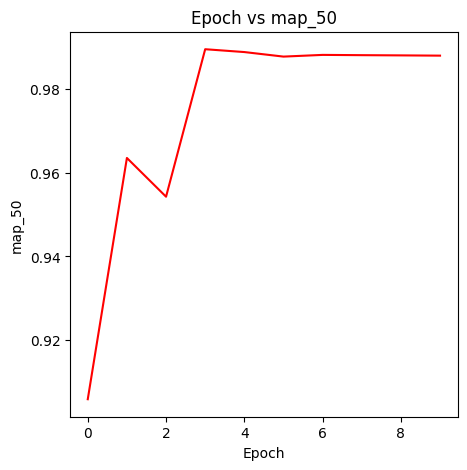

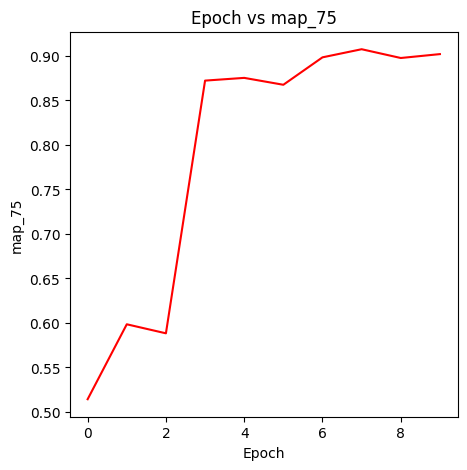

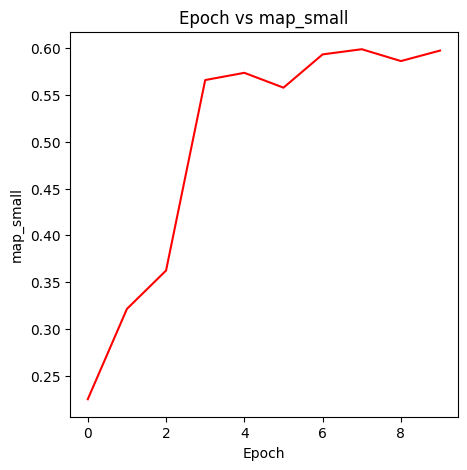

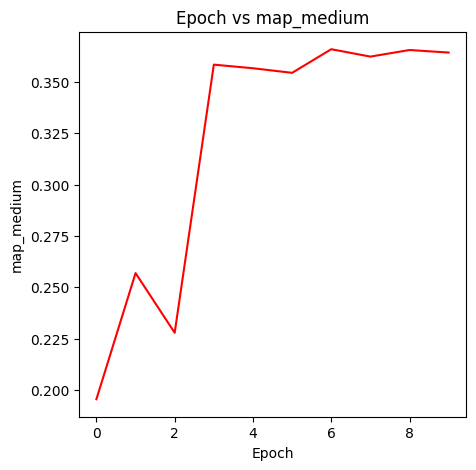

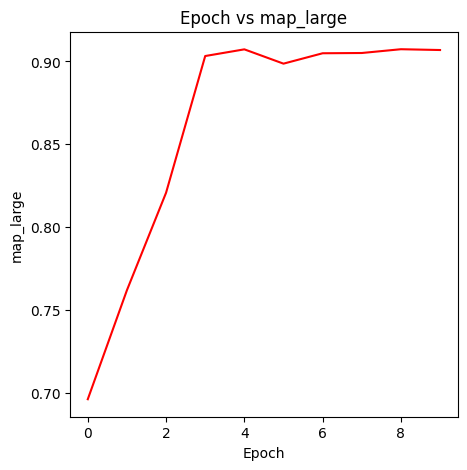

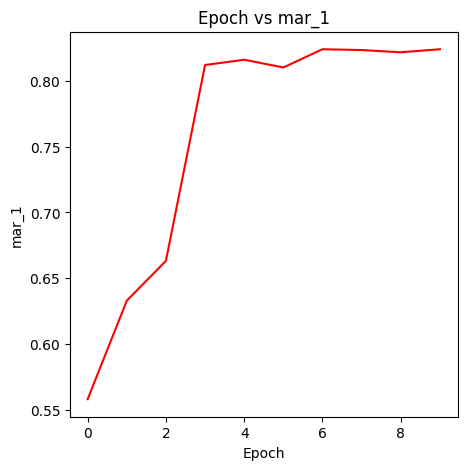

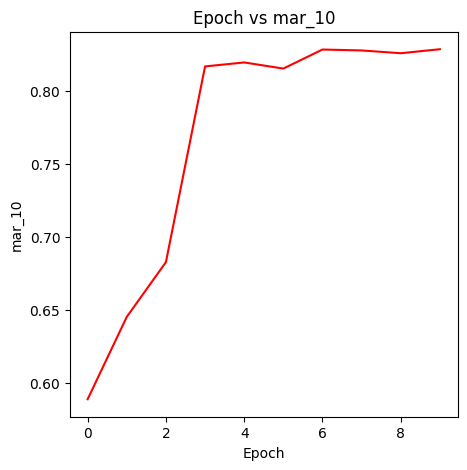

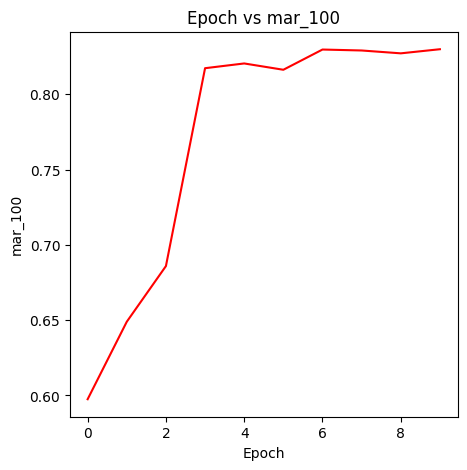

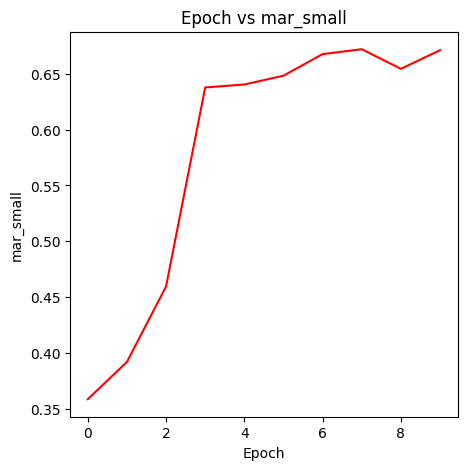

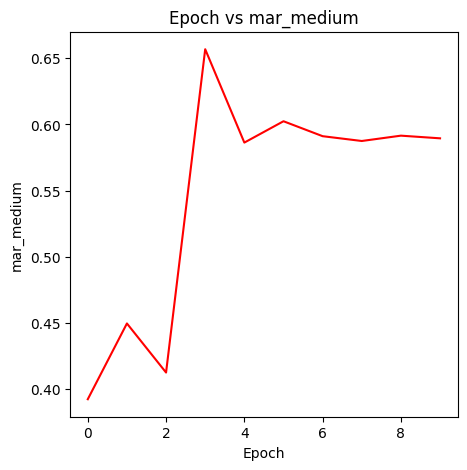

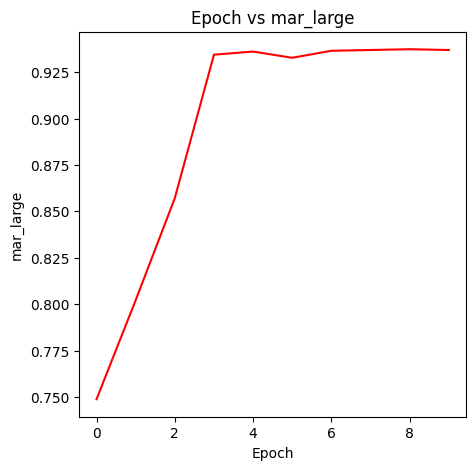

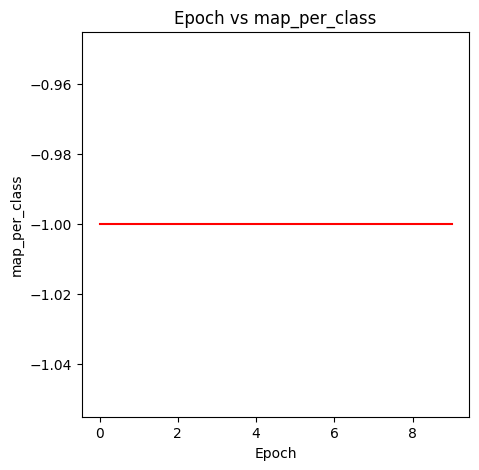

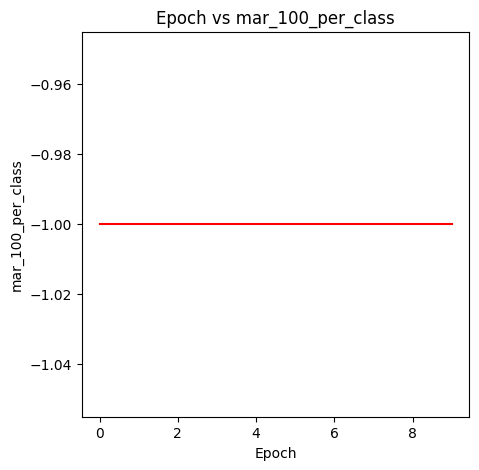

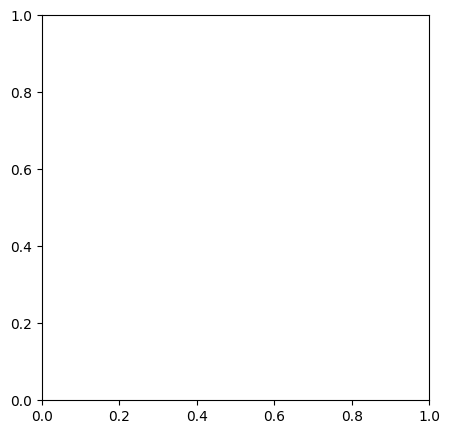

In [ ]:
df_map = pd.DataFrame(map_dict_all)
keys = df_map.keys()
for key in keys:
  try:
    plot_cost(df_map[key],key)
  except:
    pass

In [ ]:
torch.save(model, model_saved)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp "/content/model.pth" "/content/drive/MyDrive/"
# !cp "/content/drive/MyDrive/model ssd.pth" ./

In [ ]:
model_path = model_saved #"/content/drive/MyDrive/model.pth"

# model_loaded = torch.load(model_path , map_location=torch.device(device) )
model_loaded = torch.load(model_path )

v = validate_model(model_loaded,loader_valid,device)
print(v)

100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


{'map': array(0.76216143, dtype=float32), 'map_50': array(0.97914535, dtype=float32), 'map_75': array(0.86687773, dtype=float32), 'map_small': array(0.26610216, dtype=float32), 'map_medium': array(0.6282959, dtype=float32), 'map_large': array(0.8026921, dtype=float32), 'mar_1': array(0.8038717, dtype=float32), 'mar_10': array(0.81458336, dtype=float32), 'mar_100': array(0.81489915, dtype=float32), 'mar_small': array(0.3809524, dtype=float32), 'mar_medium': array(0.7660105, dtype=float32), 'mar_large': array(0.81761605, dtype=float32), 'map_per_class': array(-1., dtype=float32), 'mar_100_per_class': array(-1., dtype=float32), 'classes': array([1, 2], dtype=int32)}


#Test

t  : Elapsed time :  0.02718830108642578 seconds


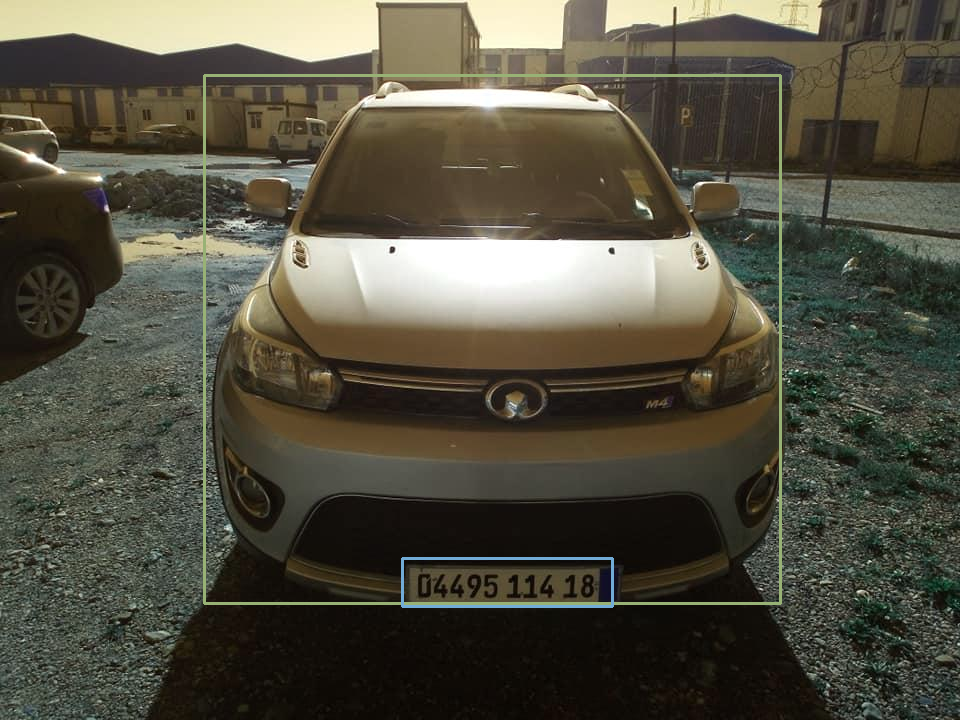

t  : Elapsed time :  0.034200429916381836 seconds


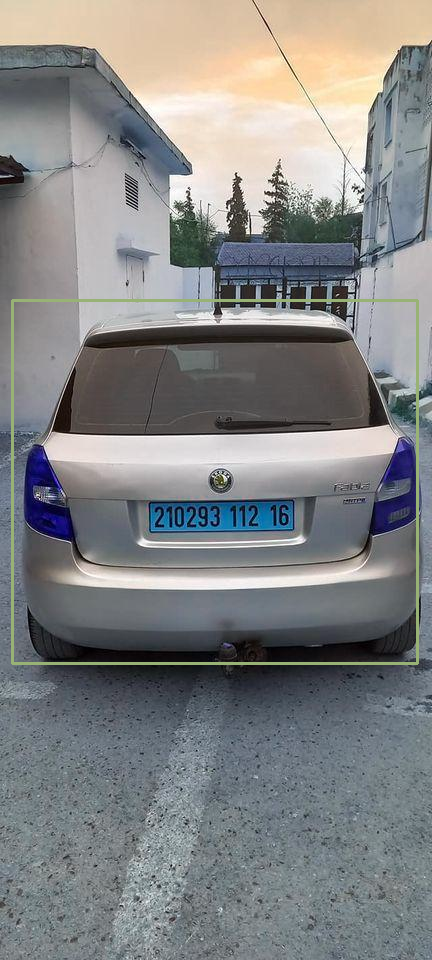

t  : Elapsed time :  0.032764434814453125 seconds


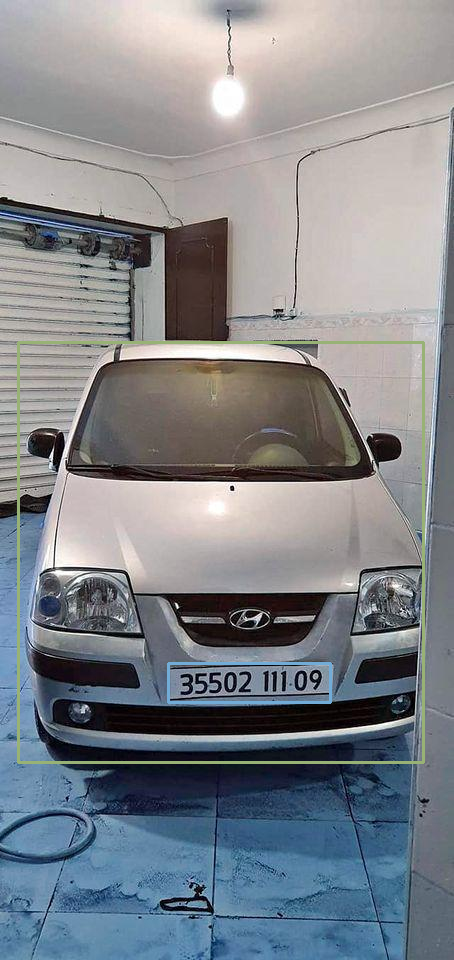

t  : Elapsed time :  0.03815650939941406 seconds


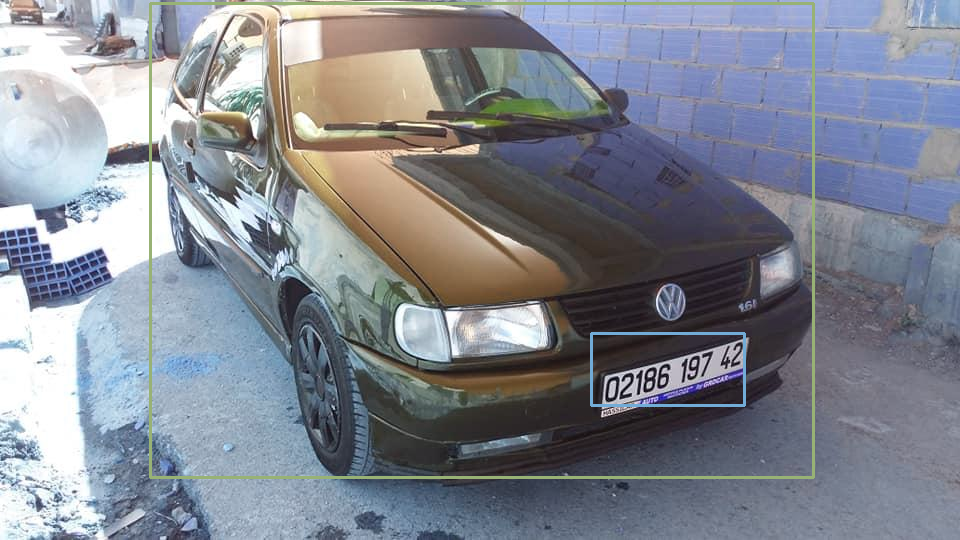

In [111]:
images_path = get_all_files(dataset_path,"jpg")
for i, p in enumerate(images_path):
  img = read_image(p)
  t = TimeExe("t")
  t.begin()
  boxes, labels = predict(img,model_loaded,device,0.4)
  t.end()
  draw_boxes(boxes , labels , img)
  cv2_imshow(img)

  if i > 2 :
    break

In [101]:
png = get_all_files("./","png")
csv = get_all_files("./","csv")
files = png + csv
print(png)
# ----------------------------------
import zipfile
output_zip_file = "_files.zip"
with zipfile.ZipFile(output_zip_file, 'w') as zipf:
    for file in files:
        zipf.write(file)
# ----------------------------------
for f in files :
  os.remove(f)

['./Epoch vs mar_small.png', './Epoch vs mar_medium.png', './Epoch vs map_per_class.png', './Epoch vs map_large.png', './Epoch vs mar_100.png', './Epoch vs lr.png', './Epoch vs map_50.png', './Epoch vs map_medium.png', './Epoch vs classification.png', './Epoch vs mar_10.png', './Epoch vs mar_large.png', './Epoch vs map_75.png', './Epoch vs bbox_regression.png', './Epoch vs map_small.png', './Epoch vs mar_100_per_class.png', './Epoch vs mar_1.png', './Epoch vs map.png']


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch
from ultralytics import YOLO


model = YOLO('./_GARIAMAN/models/car+plate_416.pt')

In [5]:
# Validation
model.val(data="./data.yaml")

Ultralytics 8.3.55  Python-3.9.12 torch-2.2.2+cpu CPU (11th Gen Intel Core(TM) i5-11400H 2.70GHz)


100%|██████████| 755k/755k [00:00<00:00, 1.41MB/s]
val: Scanning C:\Users\ait7m\Documents\Yolo_parking\datasets\dataset\car-plate\valid\labels... 475 images, 0 backgrounds, 0 corrupt: 100%|██████████| 475/475 [00:00<00:00, 2095.31it/s]

val: New cache created: C:\Users\ait7m\Documents\Yolo_parking\datasets\dataset\car-plate\valid\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.21it/s]


                   all        475        955      0.998      0.989      0.995      0.913
                   car        475        480      0.997      0.988      0.995      0.962
                 plate        475        475          1      0.991      0.995      0.863
Speed: 0.2ms preprocess, 11.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\val19


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D20F9B03D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [12]:
# test
resulttest = model.val(data="./data.yaml", imgsz=320)

Ultralytics 8.3.55  Python-3.9.12 torch-2.2.2+cpu CPU (11th Gen Intel Core(TM) i5-11400H 2.70GHz)


val: Scanning C:\Users\ait7m\Documents\Yolo_parking\datasets\dataset\car-plate\test\labels.cache... 238 images, 0 backgrounds, 0 corrupt: 100%|██████████| 238/238 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


                   all        238        478      0.997      0.995      0.995      0.918
                   car        238        240      0.994      0.992      0.995      0.964
                 plate        238        238          1      0.999      0.995      0.871
Speed: 0.3ms preprocess, 22.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\val32


In [13]:
ocr_data = YOLO('./_GARIAMAN/models/ocr_224.pt')

In [14]:
model.val(data="./ocr-data.yaml")

Ultralytics 8.3.55  Python-3.9.12 torch-2.2.2+cpu CPU (11th Gen Intel Core(TM) i5-11400H 2.70GHz)


val: Scanning C:\Users\ait7m\Documents\Yolo_parking\datasets\dataset\ocr-dz-v2\test\labels... 42 images, 0 backgrounds, 0 corrupt: 100%|██████████| 42/42 [00:00<00:00, 473.64it/s]

val: New cache created: C:\Users\ait7m\Documents\Yolo_parking\datasets\dataset\ocr-dz-v2\test\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]


IndexError: index 9 is out of bounds for axis 1 with size 3

In [15]:
model.

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
   